## 作业1：跳伞运动员仿真
   一名高空跳伞运动员从飞机上跳下，能够确定海拔高度和运动员自由下落的速度吗？在上一个实例中，炮弹总是保持$500m/s$的水平初速度（直到落入海中）。实际情况下，空气的摩擦阻力将使炮弹减速。同样，作用在运动员身上的重力同样受到空气摩擦力的影响，并随着运动员速度的增加而变大。最终，这一阻力将导致向上的摩擦力与向下的重力平衡，使合外力为零。在这一点，运动员将不再加速并保持稳态速度。
    根据基本空气动力学理论，运动员所受阻力由下式表示：
$$drag={1\over2}\rho v^2SC_d$$
式中，$\rho$为空气密度，$v$为速度，$S$为表面积，$C_d$为阻力系数。
    该公式的计算显然比较复杂。首先，空气密度$\rho$随着海拔高度而变化；第二，总阻力随着速度的平方变化；第三，运动员的表面积随着其运动而变化；最后，阻力系数取决于运动员伞具采用材料的摩擦力系数。这四个变量都是非线性的，因此很难推导出这个公式的显式解。
    为简化这个问题，假设$\rho=1.225kg/m^3$，$S=1.0m^2$，$C_d=0.05$，因此仅有$v$为非线性项。使用Euler法模拟整个运动过程，而不是直接求解公式。
    改变伞打开的时间，观察跳伞运动员的运动状态变化。

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *    
#使用星号（*）运算符可让Python导入modsim.py中的所有函数


In [2]:
g = 9.8    #重力加速度
m = 85     #运动员重量
d = 1.225  #密度
S = 1.0    #降落伞面积
Cd = 0.05  #阻力系数
t_open=15  #假设开伞时间点，可任意改变
dt=0.01    #步长
H=3000.0   #跳伞高度
t_end=50

init_y = State(y=3000.0 , v=0.0 )


,values
y,3000.0
v,0.0


In [3]:
system_y = System(init=init_y, g=g, t_0=0,t_end=t_open, dt=dt)

,values
init,y 3000.0 v 0.0 dtype: float64
g,9.8
t_0,0
t_end,15
dt,0.01


In [4]:
system_open = System(init=3000.0-0.5*g*t_open*t_open, g=g, t_0=t_open, t_end=t_end, dt=dt)

,values
init,1897.50
g,9.80
t_0,15.00
t_end,50.00
dt,0.01


In [5]:
def slope_func_y(state, t, system): #开伞前的状态
    y, v = state
    
    dydt = -system.g*t
    dvdt = -system.g
    
    return dydt, dvdt

def slope_func_open(state, t, system): #开伞后的状态
    y, v = state
    
    Drag=0.5*d*v*v*S*Cd
    dydt = v+(-system.g + Drag/m)*t
    dvdt = -system.g + Drag/m
    
    return dydt, dvdt

Vy, Ay = slope_func_y(system_y.init, 0, system_y)

In [6]:
def modified_run_euler(system, slope_func, result_y=0, H_0=3000.0, t_part=15, **options): #修改过的欧拉法函数
    '''从modsim.py中找到run_euler函数的源代码，然后进行了修改
    通过result_y来将开伞前后的状态连接起来
    由于高度大于0的限制仿真结束时可能最后时间点可能不等于t_end,用t_part来记录结束时间点'''
    
    
    # the default message if nothing changes
    msg = "The solver successfully reached the end of the integration interval."

    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    if H_0==3000.0: #若初始高度为3000.0米
        frame = TimeFrame(columns=init.index)
        frame.row[t_0] = init
        ts = linrange(t_0, t_end, dt) * get_units(t_end)
        # run the solver
        for t1 in ts: 
            y1 = frame.row[t1]
            if y1.y>=0:   #判断是否到达地面
                slopes = slope_func(y1, t1, system)
                y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
                t2 = t1 + dt
                frame.row[t2] = y2
                t_part=t2
            else:
                break    #到达地面则停止仿真
                
    else:          #若初始高度不为3000.0米
        frame=result_y
        ts = linrange(t_part, t_end, dt) * get_units(t_end)
         # run the solver
        for t1 in ts: 
            y1 = frame.row[t1]
            if y1.y>=0:   #判断是否到达地面
                slopes = slope_func(y1, t1, system)
                y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
                t2 = t1 + dt
                frame.row[t2] = y2
            else:
                break    #到达地面则停止仿真
                
    
    details = ModSimSeries(dict(message="Success"))
    return frame, details,t_part


In [7]:
#开伞之前的仿真
results_y_1, details_y_1,t_part_1 = modified_run_euler(system_y, slope_func_y)

In [8]:
#开伞之后的仿真
results_y_2, details_y_2,t_part_2 = modified_run_euler(system_open, slope_func_open, results_y_1, system_open.init,t_part_1)

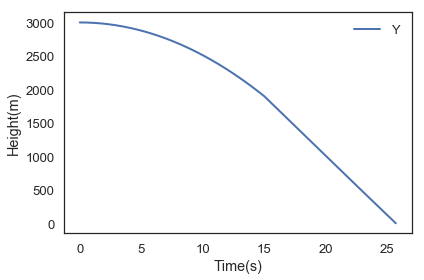

In [9]:
plot(results_y_2.y, label='Y')
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

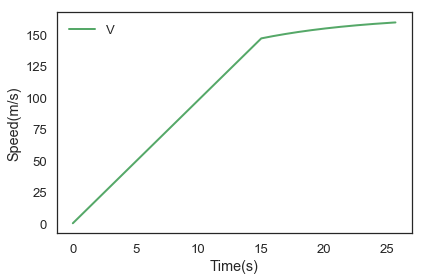

In [10]:
plot(-results_y_2.v,'g', label='V')
decorate(xlabel='Time(s)',
         ylabel='Speed(m/s)')